# Predict the closing price, Model: SARIMAX, Stock Token: CMG, Train/Test/Validation/: 60/20/20
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 858.92
- MAE: 595.5923714924096
- MAPE: 1.78 %

### Import neccesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Choose the split_type and stock_name -> CMG - 6 2 2
split = 1  # 6 2 2
stock = 1  # CMG

## 1.Data preprocessing


In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1247,2024-02-26,39900,40200,39500,40000,102000,CMG
1248,2024-02-27,40000,40200,39400,40200,135100,CMG
1249,2024-02-28,40200,40200,39600,40000,177200,CMG
1250,2024-02-29,40000,40000,37600,39950,347700,CMG


In [5]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [6]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [7]:
# Shape of the dataframe
df.shape

(1252, 2)

In [8]:
df.dtypes

low      int64
close    int64
dtype: object

In [9]:
# Describe the dataframe
df.describe()

,low,close
count,1252.000000,1252.000000
mean,25239.357827,25802.539137
std,8728.202150,8986.348803
min,10780.000000,10880.000000
25%,17455.000000,17710.000000
50%,25175.000000,25925.000000
75%,32340.000000,33325.000000
max,43600.000000,44150.000000


## 2. Train model


In [10]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [11]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [12]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

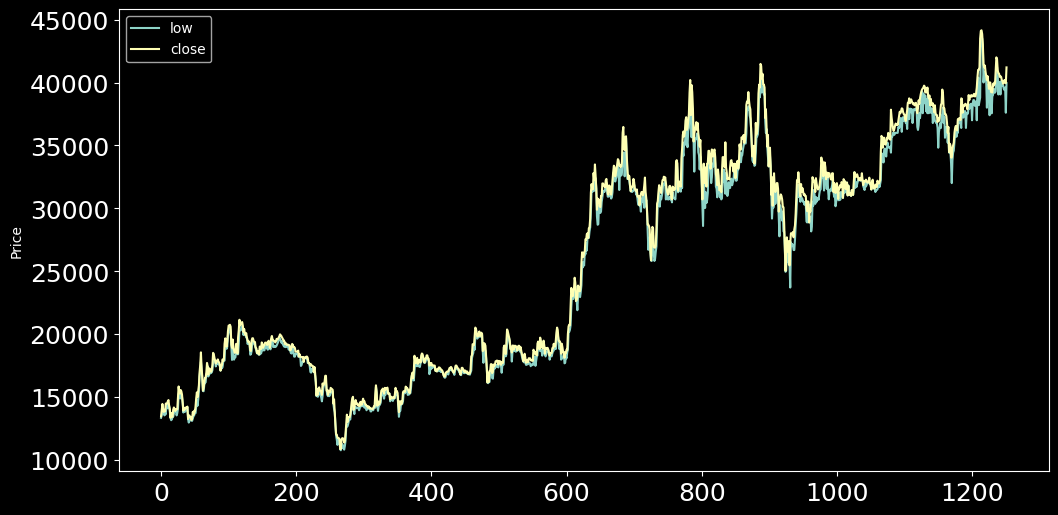

In [13]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [14]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-0.7532061524789402,
 0.832482618456889,
 12,
 1239,
 {'1%': -3.435638861796935,
  '5%': -2.863875547501718,
  '10%': -2.5680134763122906},
 19254.366836531663)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [15]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [16]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.803
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.827
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


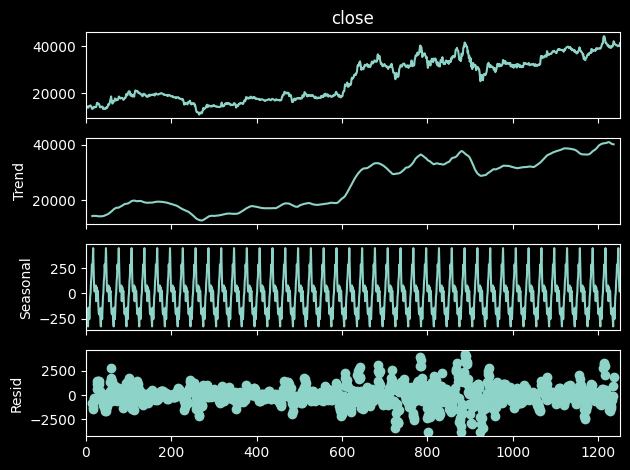

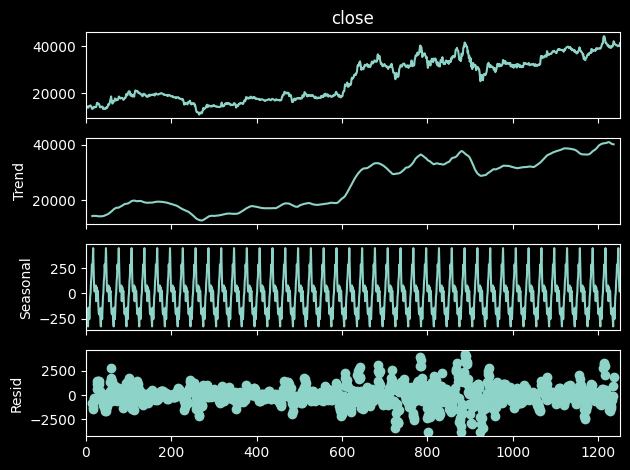

In [17]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [18]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [19]:
# Check again
adfuller(df_diff)

(-13.145394465115874,
 1.401699046775634e-24,
 3,
 746,
 {'1%': -3.439146171679794,
  '5%': -2.865422101274577,
  '10%': -2.568837245865348},
 11020.264119577547)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

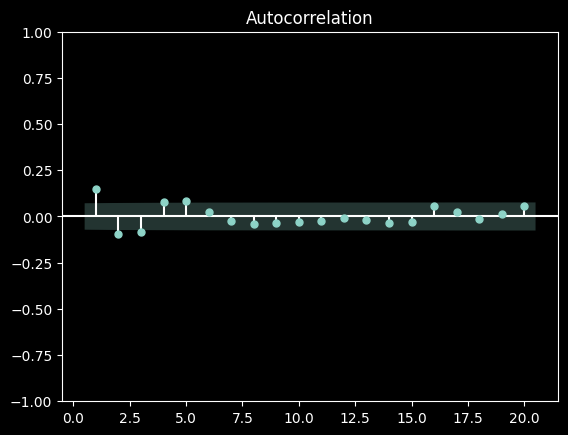

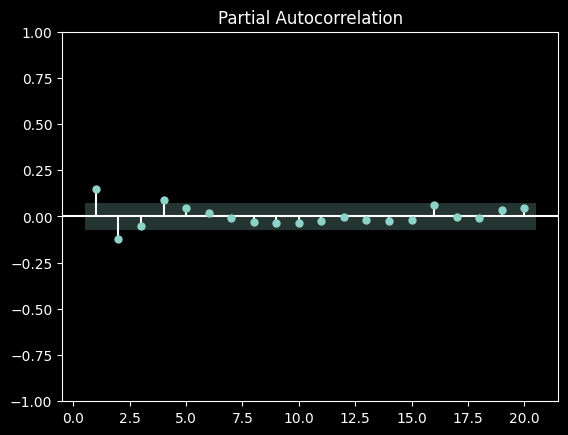

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [21]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [22]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=11336.301, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=11358.607, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=11341.572, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=11338.471, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=11358.488, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=11334.308, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=11332.860, Time=0.08 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=11334.319, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=11340.121, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=11336.946, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[5] intercept   : AIC=11334.852, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[5] intercept   : AIC=11334.870, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=11341.072, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[5] intercept   : AIC=11335.739, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0

In [23]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  751
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -5661.243
Date:                Sun, 26 May 2024   AIC                          11332.486
Time:                        13:22:28   BIC                          11355.586
Sample:                             0   HQIC                         11341.387
                                - 751                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1313      0.176      0.747      0.455      -0.213       0.476
ar.L2         -0.5084      0.116     -4.390      0.000      -0.735      -0.281
ma.L1          0.0320      0.176      0.182      0.8

#### Use SARIMAX to train model


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(2, 1, 2),
    seasonal_order=(0, 0, 0, 5),
)

model_fit = model1.fit()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [25]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([31325.30155222, 31386.6241965 , 31543.35921301, 31324.81462041,
       31374.26823616, 31099.06078571, 31885.84261702, 31433.43919005,
       31433.43759513, 31433.4378309 , 31325.25648491, 32269.38568189,
       34285.49488887, 33567.56331416, 31885.83319003, 31994.01466011,
       32161.20420463, 32495.58329368, 31935.00658557, 32436.57521914,
       32220.21227917, 35121.44261062, 34728.05544703, 35790.20078872,
       35573.83784875, 36360.61217592, 37471.93091305, 35849.20886326,
       35406.64830422, 36685.15658588, 36911.35420494, 38032.50762116,
       39763.41114095, 37914.49147209, 36183.5879523 , 37747.30192756,
       37029.37035402, 35849.20886326, 33498.72056082, 35849.20886326,
       36075.40648232, 36075.40648232, 36468.79364591, 36360.61217592,
       35013.26114063, 34787.06352157, 33665.91010535, 34678.88205158,
       34118.30534347, 32436.57521914, 30764.67977389, 29250.13919408,
       32996.16845934, 31826.82511558, 30656.49830391, 31885.83319012,
      

#### Validate


In [26]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([31905.54761851, 31307.94676378, 31258.15351941, 31826.38325398,
       31295.59080345, 31905.50447106, 31866.17325884, 31600.62873458,
       31443.27227422, 31905.50242721, 31826.82511848, 32180.87357008,
       31944.84126553, 31866.16383165, 32642.12001202, 31639.96621288,
       32407.07118188, 31679.30492923, 31826.82511558, 31679.30492923,
       31600.62749652, 31984.17998101, 31826.82511558, 31679.30492923,
       32062.85741373, 33449.54716538, 32220.21227917, 32682.44219638,
       32289.05503279, 32525.08733095, 32750.3014821 , 32908.63981544,
       32829.96238273, 32987.31724816, 32790.62366637, 32829.96238273,
       32829.96238273, 32829.96238273, 32367.73246551, 32220.21227917,
       32062.85741373, 32710.96276574, 32328.39374915, 32446.40989823,
       32642.12001211, 32682.44219638, 32682.44219638, 32564.4260473 ,
       32564.4260473 , 32446.40989823, 32102.19613009, 32525.08733095,
       32407.07118187, 32289.05503279, 32180.87356281, 32180.87356281,
      

### Predict the next 30/60/90 days


In [27]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [28]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [29]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[35473.15289683 35502.81285057 35509.86902746 35525.19807975
 35542.98900496 35560.66327393 35578.18148297 35595.68399904
 35613.19310903 35630.70404971 35648.21487861 35665.72558789
 35683.2362864  35700.74699015 35718.25769526 35735.76840026
 35753.27910517 35770.78981007 35788.30051498 35805.81121989
 35823.3219248  35840.83262971 35858.34333462 35875.85403953
 35893.36474444 35910.87544935 35928.38615426 35945.89685917
 35963.40756408 35980.91826899]


### Plotting the data


In [30]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

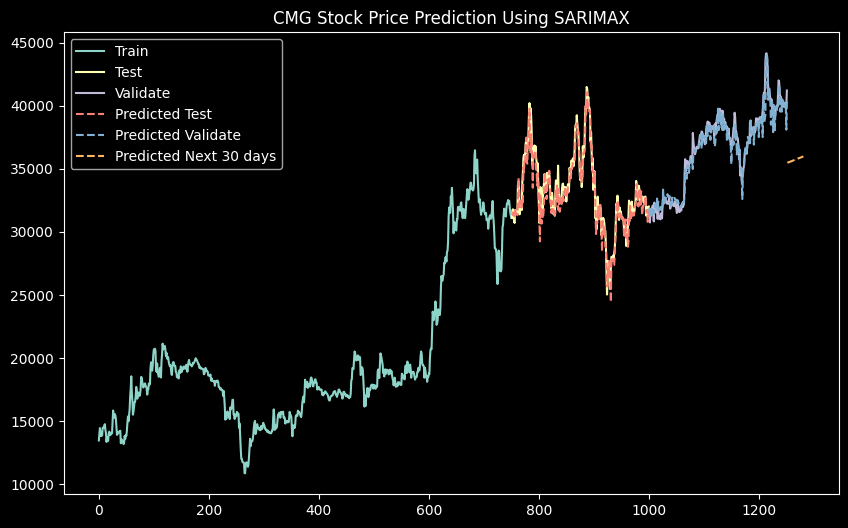

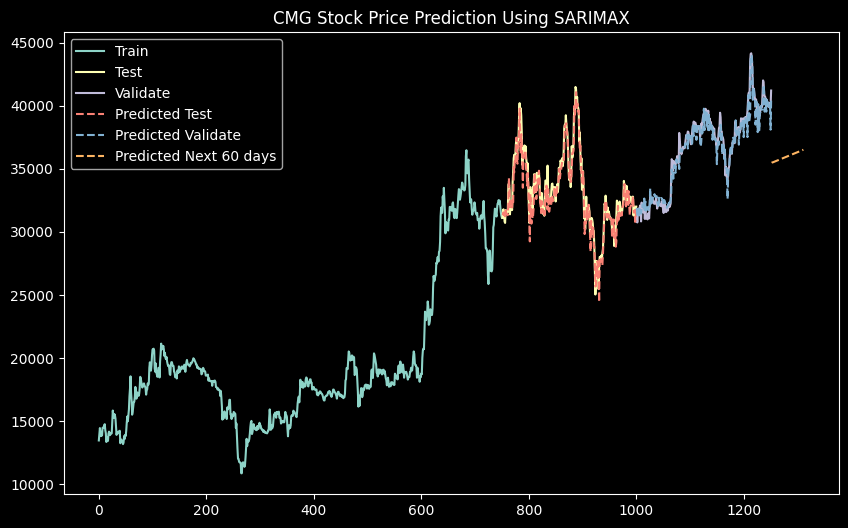

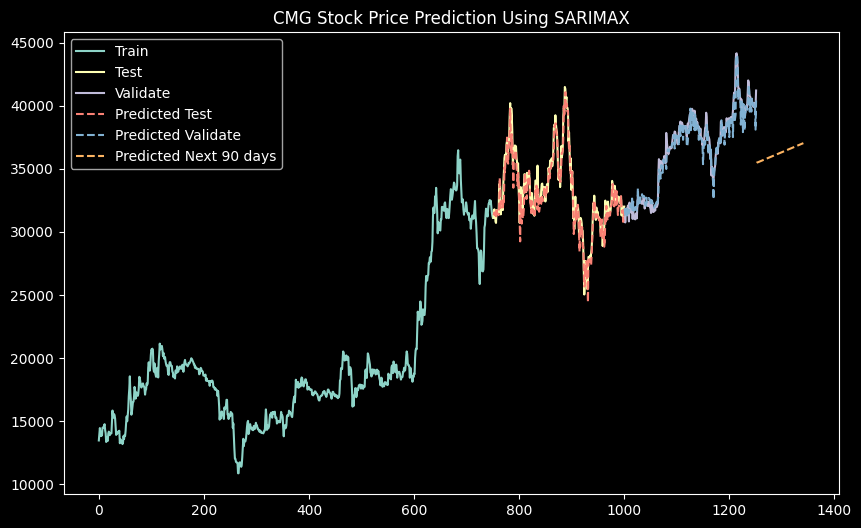

In [31]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [32]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 858.9172009843707
MAE on test data: 595.5923714924096
MAPE on test data: 1.78273144502931 %


In [33]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 716.0555303972199
MAE on validation data: 475.3711826699689
MAPE on validation data: 1.2869950048591652 %
